# Stage 0: Cleaning Up the Data

In [ ]:
import pathlib
from pathlib import Path               # Used to save files
import tensorflow as tf                # Used to create the neural network
from tensorflow import keras
import pandas as pd                    # Formats large amounts of output
import numpy as np                     # Allows flexible and efficient array operations
from matplotlib import pyplot as plt   # Used for graphics
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from PIL import Image, ImageOps        # Used to format training and testing images
from random import randrange           # Used to generate some visual elements

<p>AI models can't work with just any images or data, the dataset provided needs to be of consistent format. We begin by specifying where we're storing our three datasets.</p>
<p>The directory provided is expected to be structured in the following format. Quotation marks indicate required names.</p>
<ul>
    <li>directory</li>
    <li>----- "evaluation_data"</li>
    <li>---------- category1</li>
    <li>-------------- image1</li>
    <li>-------------- image2</li>
    <li>-------------- ...</li>
    <li>---------- category2</li>
    <li>-------------- (same as category1)</li>
    <li>---------- ...</li>
    <li>----- "training_data"</li>
    <li>---------- (same as evaluation_data)
    <li>----- "validation_data"</li>
    <li>---------- (same as evaluation_data)</li>
</ul>

In [ ]:
IMAGE_DIRECTORY = 'ai_data'
TARGET_SIZE = (512, 384)
DOWNSCALED_SIZE = 64

<p>Now we iterate through the directory and convert each image outside of the target size to match the target size.</p>
<p><b>IMPORTANT NOTE: </b>This code was run on the original 500MB dataset, the provided images are already formatted properly. If this cell is run it will just blow up the low-quality images and take up a lot more memory.</p>

In [ ]:
directory = pathlib.Path(IMAGE_DIRECTORY)

for folder1 in directory.iterdir():
    for folder2 in folder1.iterdir():
        for file in folder2.iterdir():
            image = Image.open(pathlib.Path(file))
            if image.size != (TARGET_SIZE[0], TARGET_SIZE[1]):
                if image.size[0] < TARGET_SIZE[0]:
                    image = image.resize((TARGET_SIZE[0], round((TARGET_SIZE[0] * image.size[1]) / image.size[0])))
                elif image.size[0] > TARGET_SIZE[0]:
                    image.thumbnail(TARGET_SIZE[0], 1080)
                if image.size[1] < TARGET_SIZE[1]:
                    image = image.resize((round((TARGET_SIZE[0] * TARGET_SIZE[1]) / image.size[1]), TARGET_SIZE[1]))
                    left = round(abs(TARGET_SIZE[0] - image.size[0]) / 2)
                    image = image.crop((left, 0, image.size[0], image.size[1]))
                    right = (image.size[0] - abs(TARGET_SIZE[0] - image.size[0]))
                    image = image.crop((0, 0, right, image.size[1]))
                elif image.size[1] > TARGET_SIZE[1]:
                    top = round(abs(TARGET_SIZE[1] - image.size[1]) / 2)
                    image = image.crop((0, top, image.size[0], image.size[1]))
                    bottom = (image.size[1] - abs(TARGET_SIZE[1] - image.size[1]))
                    image = image.crop((0, 0, image.size[0], bottom))

                image.save(pathlib.Path(file)) 

<p>In addition to cropping images to be the same size, the AI also doesn't need the amount of detail in this dataset. A much lower resolution is far more efficient, so all of the large images are turned into much smaller versions of themselves.</p>

In [ ]:
for folder1 in directory.iterdir():
    for folder2 in folder1.iterdir():
        for file in folder2.iterdir():
            image = Image.open(pathlib.Path(file))
            image.thumbnail((DOWNSCALED_SIZE, DOWNSCALED_SIZE))
            image.save(pathlib.Path(file))

<hr>

# Stage 1: Configuring the AI Model

<p>Configuring the model starts by defining where your training and testing folders are located.</p>

In [14]:
TRAINING_DIR = 'ai_data/training_data'
VALIDATION_DIR = 'ai_data/validation_data'
EVALUATION_DIR = 'ai_data/evaluation_data'

<p>Next, we define the shape of our downsized input images in the format (width, height, color channels). Grayscale images have a single color channel and the colored images in this set have three, representing RGB values.</p>

In [ ]:
INPUT_SHAPE = (48, 64, 3)

<p>We also tell the training iterator to interpret each tiny image as a series of values between 0 and 1 with 255 possible values. Essentially, we're converting the colors into AI-friendly format.</p>

In [ ]:
training_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

<p>Next are the training and validation generators, which are used to train the AI. The training set teaches the AI what each food category looks like, and each scan-through of the training images ends with an additional scan of the validation set, a smaller collection of new images to tell the AI whether or not it's on the right track.</p>

<p>Target size is arbitrarily chosen and just needs to divide evenly by 2 repeatedly (in this case 64 and 48). Class mode lets the network know that each image should be interpreted as belonging to a single category of something.</p>

In [15]:
training_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode = 'categorical'
)

Found 9400 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


<p>We then construct the neural network layer by layer. The general structure is based off of a successful model I previously made to recognize clothing using the Fashion MNIST database (a much larger and ideally-photographed collection of clothing items).</p>

<p>There are dozens of layer types available to the Keras library, but to summarize those used here:</p>
<ul>
    <li><b>Conv2D Layer</b> - Apply either 64 or 128 filters to the processed images in an effort to makes patterns more visible.</li>
    <li><b>MaxPooling2D Layer (2, 2)</b> - Compress the image to a quarter of their original size.</li>
    <li><b>Flatten Layer</b> - Flattens the input with all of its filters for ease of further processing.</li>
    <li><b>Dropout Layer</b> - Occasionally sets input units to zero, used to prevent overfitting (thoughtless memorization of provided examples).</li>
    <li><b>Dense Layer</b> - These are the layers where the learning happens. Nodes are strategically adjusted with each iteration to process information in a way that outputs correct answers more and more frequently.</li>
</ul>

In [16]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

<p>With the layers in place, we prepare the model to start taking input and outputting the accuracy after each iteration.</p>

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

<p>This next part is for the last section of the notebook to be able to start with a completely untrained model.</p>

In [ ]:
model.save('food_recognition_model.model')

<hr>

# Stage 2: Teaching the AI Model what Real Food Looks Like

<p>With the model set up, we just need to tell it to start learning and for how long. Each iteration through the training / validation sets is called an "epoch". For this small dataset and my very out-of-date PC, each epoch requires about 45 seconds if no background processes are running.</p>

<p>The next cell trains the model for 60 epochs, which takes about 45 minutes. The only data output from this cell is the AI's percent accuracy against the validation set each iteration. To make better use of those 45 minutes, the next section runs through the same training process but graphs more granular and interesting metrics along the way instead.</p>

In [184]:
EPOCHS = 60
model.fit(training_generator, epochs = EPOCHS, validation_data = validation_generator, verbose = 1)

Epoch 1/5
294/294 [==============================] - 84s 285ms/step - loss: 2.0965 - accuracy: 0.2467 - val_loss: 2.1263 - val_accuracy: 0.2700
Epoch 2/5
294/294 [==============================] - 45s 152ms/step - loss: 1.8384 - accuracy: 0.3590 - val_loss: 2.0888 - val_accuracy: 0.3080
Epoch 3/5
294/294 [==============================] - 45s 155ms/step - loss: 1.7120 - accuracy: 0.4089 - val_loss: 2.2029 - val_accuracy: 0.3260
Epoch 4/5
294/294 [==============================] - 46s 157ms/step - loss: 1.5913 - accuracy: 0.4489 - val_loss: 2.2949 - val_accuracy: 0.3560
Epoch 5/5
294/294 [==============================] - 46s 158ms/step - loss: 1.4959 - accuracy: 0.4879 - val_loss: 2.5818 - val_accuracy: 0.3080


<p>The AI has now learned everything it will learn. To put it to the test, we need a small set of images the AI has never seen before. This is when the evaluation set comes into play. Starting the evaluation process in the level of detail that allows graphing results requires a very careful series of formatting steps.</p>

## THE FORMATTING

<p>This part deserves its own all-caps subsection just because of how unexpectedly involved it was.<p>
<p>Keras processes input images in groups called "batches", whose size must evenly divide into the size of your collection to avoid missing any near the end of the list. With an evaluation set size of 100, 10 is selected.</p>

In [17]:
BATCH_SIZE = 10

Found 100 files belonging to 10 classes.


<p>Next we create an iterator to run through the images of the evaluation set.</p>

In [ ]:
images_dataset = tf.keras.preprocessing.image_dataset_from_directory(EVALUATION_DIR, 
                                                                     image_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                                     shuffle = False,
                                                                     label_mode = 'categorical',
                                                                     batch_size = BATCH_SIZE)

<p>For ease of converting human-readable categories to AI-readable integers, we convert the list of provided categories into a dictionary to map labels to index locations.</p>

In [ ]:
# Sets up some convenient methods of mapping the spelled-out categories to integers
CATEGORIES = images_dataset.class_names
NUM_CATEGORIES = len(CATEGORIES)
CAT_TO_INT_MAP = {}

for i, cat in enumerate(CATEGORIES):
    CAT_TO_INT_MAP[cat] = i

<p>Finally, we compile the evaluation images into lists, being careful to specify the data type to make the dataset consumable with the AI model.</p>

In [ ]:
testing_images_a = []
testing_labels_a = []
for images, labels in images_dataset.take(len(images_dataset)):
    for j in range(BATCH_SIZE):
        testing_images_a.append(images[j].numpy().astype('uint8'))
        testing_labels_a.append(labels[j].numpy().astype('uint8'))
            
            
testing_images_a = np.array(testing_images_a)
testing_labels_a = np.array(testing_labels_a)

## Evaluation

<p>The model is now ready to be tested against the 100-image evaluation set. Unlike the training process, this only takes seconds using the following call:</p>

In [26]:
model.evaluate(testing_images_a, testing_labels_a)

4/4 [==============================] - 0s 24ms/step - loss: 48.6553 - accuracy: 0.0900


[48.655296325683594, 0.09000000357627869]

<p>With this final step, we've successfully trained and evaluated the AI against our evaluation set. The data output by this evaluation, however, isn't much of a performance analysis, moreso a vague letter-grade with no explanation of where the score came from. To expand on these high-level metrics, we use a series of graphs during the AI's training in the next section.

<hr>

# Stage 3: Performance Analysis

<p>Performance analysis begins with a few functions that will be used to save the AI's predictions in detail as visualizations. This is done in three mediums:</p>
<ul>
    <li>A heat map to show the AI's certainty for each category in every image</li>
    <li>A dendrogram using hierarchical clustering to display the AI's similarity predictions between images</li>
    <li>A series of line graphs to show the AI's accuracy against the evaluation set each epoch, overall and per category</li>
</ul>

In [19]:
# Initialize functions to turn AI training results into visualizations

def saveHeatmap(categories, predictions, labels, target_directory):
    """ Converts the provided data into a heatmap graphed one cluster at a time, then saves the image. """
    
    # Organize the data into hierarchical clusters
    hc = AgglomerativeClustering(n_clusters = len(categories), affinity = 'euclidean', linkage = 'ward')
    predictions_c = hc.fit_predict(predictions)

    plot_data = []

    # Create a sorted array one cluster at a time to display an organized heatmap
    for i in enumerate(categories):
        for j in enumerate(labels):
            if j[1] == i[0]:
                plot_data.append(predictions[j[0]].tolist())

    # Convert the sorted array into a labeled data table
    plot_data_df = pd.DataFrame(plot_data)
    plot_data_df.columns = categories

    # Display the labeled data table as a heat map
    sns.set(rc = {'figure.figsize': (8, 10)})
    display = sns.heatmap(plot_data_df)
    plt.title('Confidence per Category per Picture Heatmap', fontsize = 20)
    plt.xlabel('Category', fontsize = 16)
    plt.ylabel('Picture #', fontsize = 16)
    plt.savefig(target_directory)
    plt.show()
    
    

def saveDendrogram(predictions, target_directory):
    """ Converts the provided prediction data into a hierarchically-clustered dendrogram, then saves the image. """
    sns.set(rc = {'figure.figsize': (16, 12)})
    dendrogram = sch.dendrogram(sch.linkage(predictions, method = 'ward'), leaf_font_size = 10)
    plt.title('Hierarchically Clustered Dendrogram', fontsize = 20)
    plt.xlabel('Picture #', fontsize = 16)
    plt.ylabel('Level', fontsize = 16)
    plt.gcf()
    plt.savefig(target_directory)
    
    

def saveLineGraphs(accuracy_dict, parent_directory):
    """ 
        Converts the provided accuracy data per epoch into multiple line graphs.
        The first line graph is for overall accuracy only.
        The remaining line graph are for each category.
    """
    plt.clf()
    sns.set(rc = {'figure.figsize': (8, 10)})
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.title('AI Accuracy per Epoch', fontsize = 20)
    overall_x = accuracy_dict['epoch']
    overall_y = accuracy_dict['overall']
    plt.plot(overall_x, overall_y, color = '#0000AA', marker = '.')
    plt.savefig(parent_directory + '/linegraph_overall')
    
    
    for cat in accuracy_dict.keys():
        if cat not in ('epoch', 'overall'): # Skip the "epochs" and "overall" column
            plt.clf()
            plt.title('AI Accuracy per Epoch - {} Only'.format(cat), fontsize = 20)
            plt.xlabel('Epoch', fontsize = 16)
            plt.ylabel('Accuracy', fontsize = 16)
            line_color  = '#' + ''.join([hex(j).split('x')[-1].zfill(2) for j in [randrange(255) for i in range(3)]])
            cat_x = accuracy_dict['epoch']
            cat_y = accuracy_dict[cat]
            plt.plot(cat_x, cat_y, color = line_color, marker = '.', label = cat)
            plt.savefig(parent_directory + '/linegraph_{}'.format(cat))            

<p>We re-define our desired epochs and load the clean, untrained model from earlier here.</p>

In [ ]:
EPOCHS = 60
model = tf.keras.models.load_model('food_recognition_model.model')

<p>Here we create a folder to store the graphs and set up a data table to store accuracy per category per epoch while the model trains.</p>

In [ ]:
data_dir = 'results'
Path(data_dir).mkdir(parents = True, exist_ok = True)

accuracy_dict = {'epoch': [i for i in range(EPOCHS)]}
for cat in CATEGORIES:
    accuracy_dict[cat] = []
accuracy_dict['overall'] = []

<p>Accurate judgment of the AI calls for a list of the correct answers, so we construct that list next. We also subtly set the graphing style.</p>

In [ ]:
correct_labels = np.asarray(testing_labels_a).argmax(axis = 1)
correct_cat_counts = [len([j for j in filter(lambda x: x == i, correct_labels)]) for i in CAT_TO_INT_MAP.values()]
plt.style.use('ggplot')

<p>The AI is then run through the training process with data analysis occurring at the end of each epoch. By the end of this stage, the heatmaps are saved for each set of 5 epochs along with a single dendrogram.</p>

In [ ]:
for i in range(EPOCHS):
    model.fit(training_generator, epochs = 1, validation_data = validation_generator, verbose = 1)
    epoch_metrics = model.evaluate(testing_images_a, testing_labels_a)
    epoch_predictions_raw = model.predict(testing_images_a)
    epoch_predictions = np.asarray(epoch_predictions_raw).argmax(axis = 1)
    
    # Record the evaluation accuracy overall
    accuracy_dict['overall'].append(round(epoch_metrics[1], 2))
    
    # Record the evaluation accuracy per category
    for cat in CATEGORIES:
        count_correct_for_cat = 0
        for guess in enumerate(epoch_predictions):
            if guess[1] == correct_labels[guess[0]] and guess[1] == CAT_TO_INT_MAP[cat]:
                count_correct_for_cat += 1
        accuracy_dict[cat].append(round(count_correct_for_cat / correct_cat_counts[CAT_TO_INT_MAP[cat]], 2))

    # Every n epochs, plot and save a heatmap
    if i % 5 == 0:
        saveHeatmap(CATEGORIES, epoch_predictions_raw, correct_labels, data_dir + '/heatmap_epoch_{}'.format(i))
    
    # If the end of the loop is here, save the prediction data as a clustered dendrogram and save predictions also
    if i == EPOCHS - 1:
        saveDendrogram(epoch_predictions_raw, data_dir + '/dendrogram')
        prediction_df = pd.DataFrame({'predicted_label': [row.argmax() for row in epoch_predictions_raw]})
        prediction_df.to_csv(data_dir + '/prediction_data.csv')

<p>Since the training is over we can also save our line graphs and a raw CSV file of all the prediction data to use in the dashboard notebook. This is the table used to display the images corresponding to each decision rather than visualizing numerical data only.</p>

4/4 [==============================] - 0s 29ms/step - loss: 136.7415 - accuracy: 0.5200


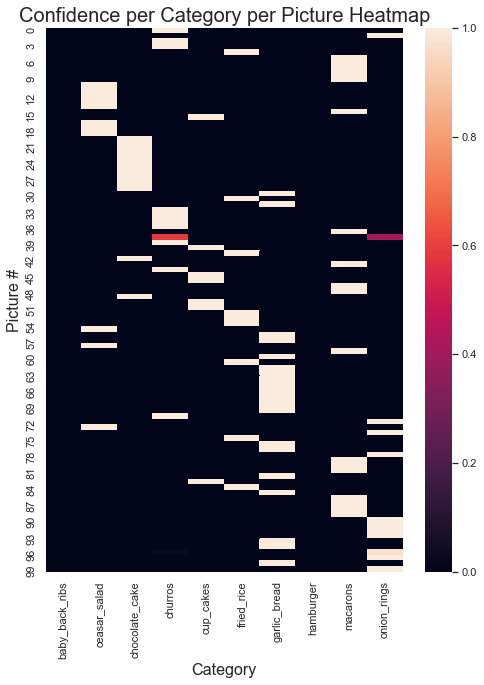

4/4 [==============================] - 0s 22ms/step - loss: 116.0558 - accuracy: 0.5700


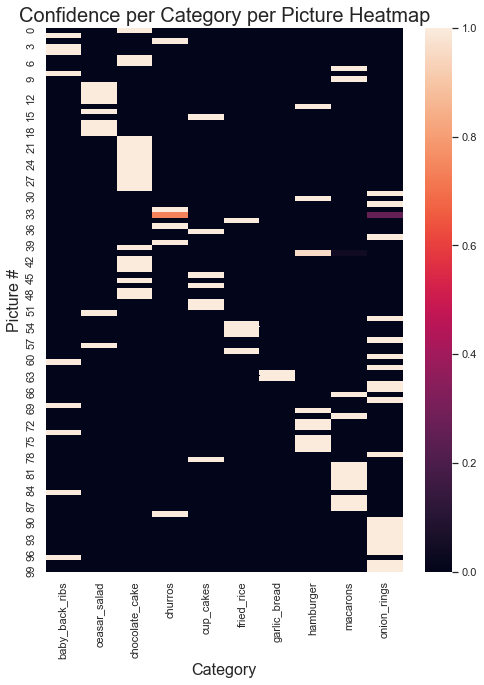

4/4 [==============================] - 0s 24ms/step - loss: 158.7458 - accuracy: 0.6700


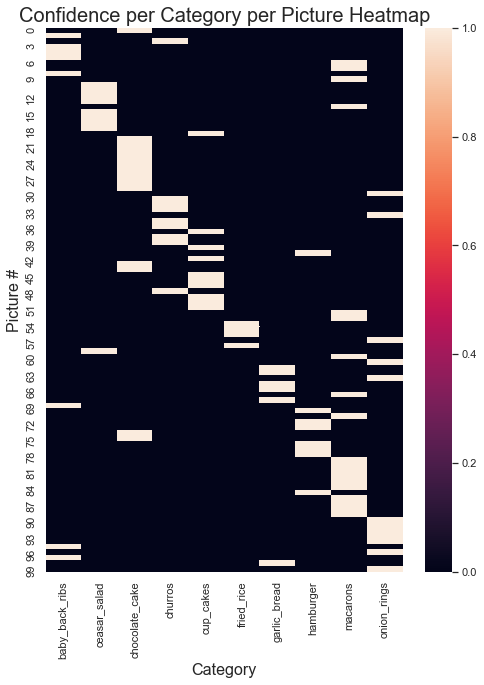

4/4 [==============================] - 0s 32ms/step - loss: 393.7336 - accuracy: 0.6100


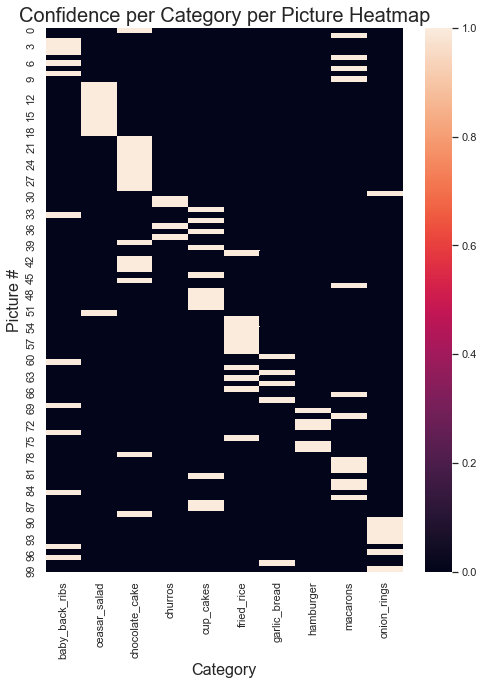

4/4 [==============================] - 0s 20ms/step - loss: 230.2355 - accuracy: 0.6300


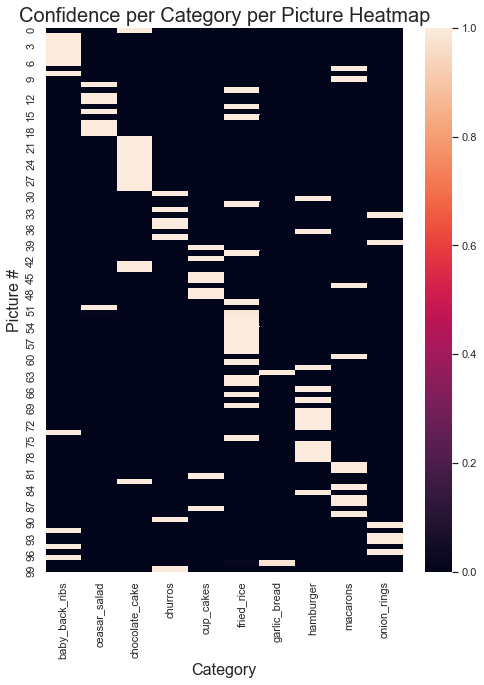

4/4 [==============================] - 0s 20ms/step - loss: 383.0537 - accuracy: 0.7200


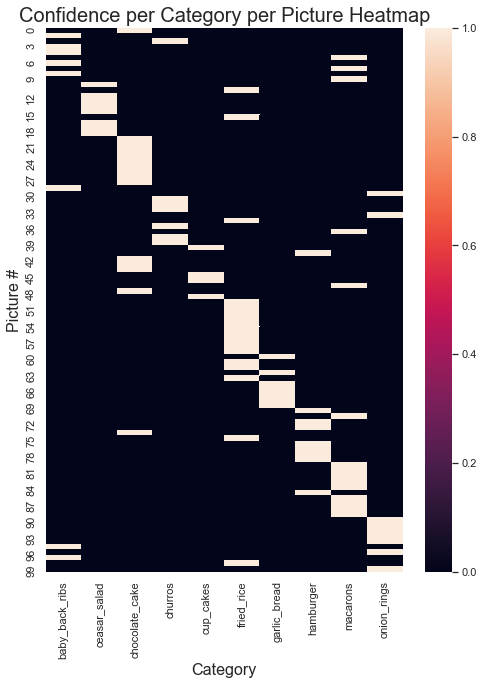

4/4 [==============================] - 0s 20ms/step - loss: 592.5377 - accuracy: 0.5200


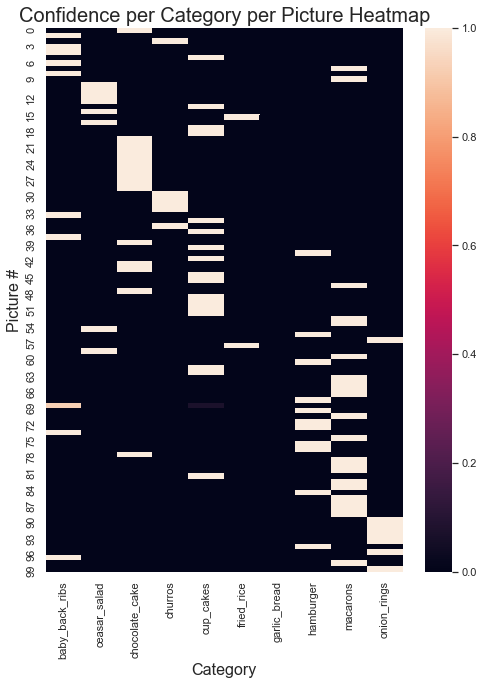

4/4 [==============================] - 0s 19ms/step - loss: 653.6451 - accuracy: 0.6500


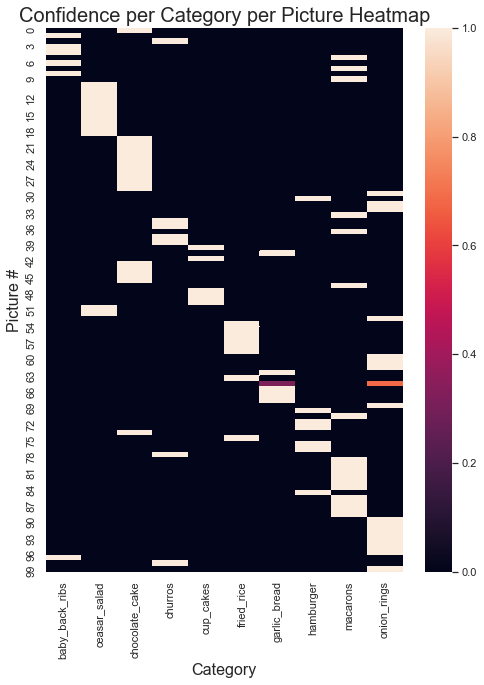

4/4 [==============================] - 0s 21ms/step - loss: 625.0836 - accuracy: 0.6300


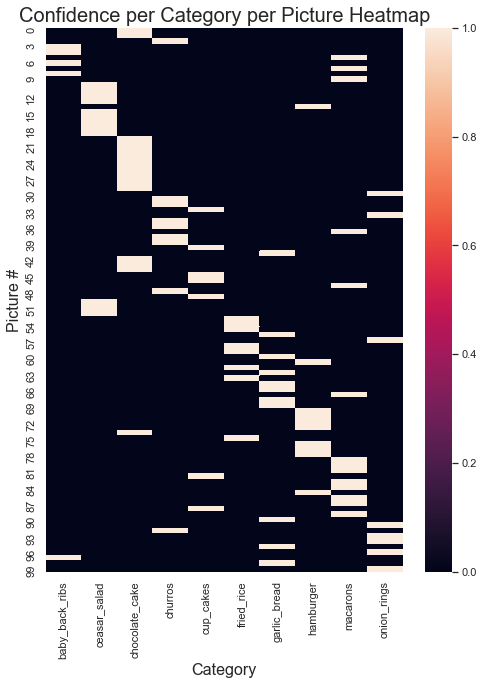

4/4 [==============================] - 0s 28ms/step - loss: 741.3042 - accuracy: 0.5700


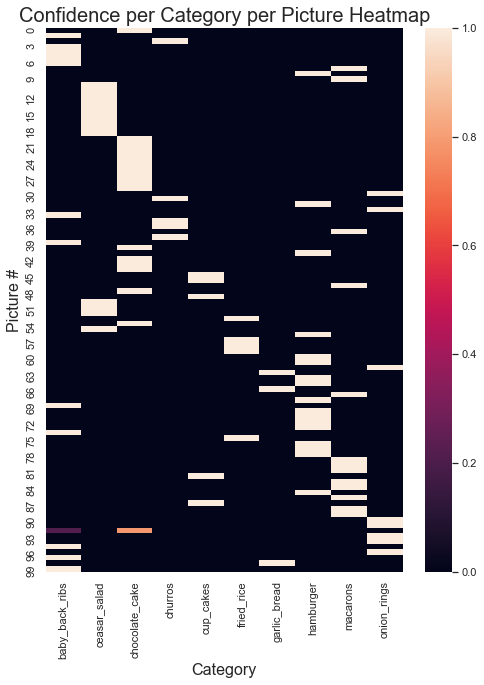

4/4 [==============================] - 0s 20ms/step - loss: 921.2951 - accuracy: 0.6500


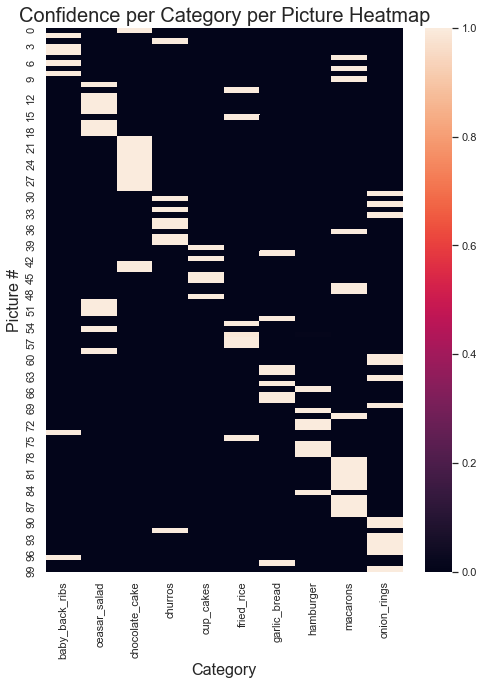

4/4 [==============================] - 0s 19ms/step - loss: 728.0276 - accuracy: 0.5700


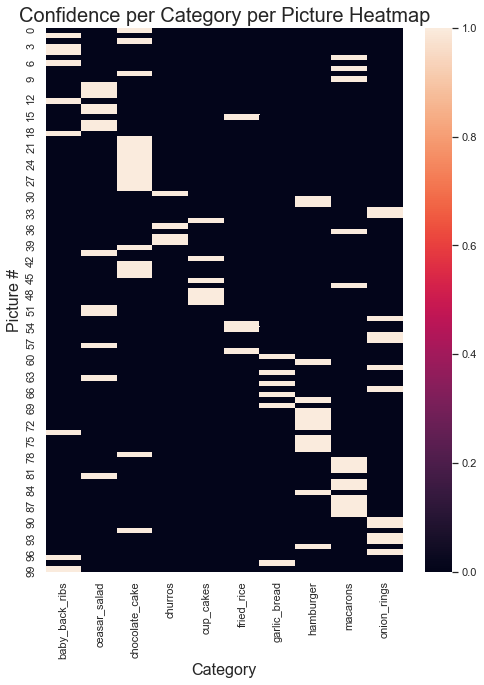

4/4 [==============================] - 0s 20ms/step - loss: 732.3607 - accuracy: 0.6700


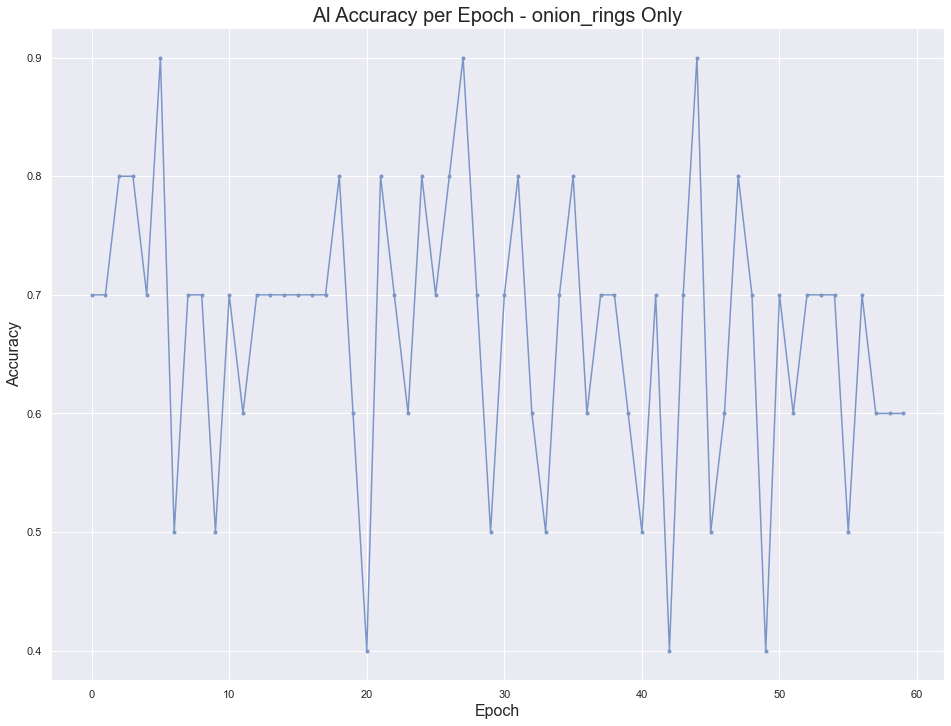

In [20]:
# Save the accuracy data as a CSV file
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.to_csv(data_dir + '/accuracy_data.csv')


# Save the accuracy data as line graphs
saveLineGraphs(accuracy_dict, data_dir)

<hr>

<p>These visualizations are converted into a less code-focused, code-focused UI in the dashboard notebook.</p>